# Position and rotation estimation with pooling layers and RGB images
## Using rotations defined by RGB values

In [105]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import random
import math

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU

# Preparing data

In [106]:
DATADIR = "dataset_generator/images/pos_and_rot_5/"
JSON_file_name = "data.txt"
IMAGES = 1_000
OG_IMG_SIZE = 800
IMG_SIZE = 150

In [107]:
data_json = []
for line in open(DATADIR + JSON_file_name, 'r'):
    data_json.append(json.loads(line))
    
dataset = [] # [x, y]

for img in os.listdir(DATADIR):
    if(img.endswith(".jpg")):
        img_array = cv2.imread(os.path.join(DATADIR, img))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        img_index = int(img.strip(".jpg"))
        for label in data_json:
            if(label['index'] == img_index):
                choosen_label = {'bx': label['bx'], 
                                 'by': label['by'], 
                                 'bw': label['bw'], 
                                 'bh': label['bh'], 
                                 'posX': label['posX'], 
                                 'posY': label['posY'], 
                                 'posZ': label['posZ'],
                                 'rx': label['rx'],
                                 'gx': label['gx'],
                                 'bxx': label['bxx'],
                                 'ry': label['ry'],
                                 'gy': label['gy'],
                                 'byy': label['byy']}
                
                xy = [img_array, choosen_label]
                dataset.append(xy)
                
        if(len(dataset)%500 ==0):
            print(f"{len(dataset)} images loaded")
        
        if(len(dataset) >= IMAGES):
            print("All images loaded")
            break
            
IMAGES = len(dataset)
print(f"{IMAGES} in total")

500 images loaded
1000 images loaded
All images loaded
1000 in total


# Creating training dataset

In [108]:
X = []
y = []

shuffled_indices = random.sample(range(0, IMAGES), IMAGES)

for i in shuffled_indices:
    
    pixels = dataset[i][0]
    pixels = pixels.astype('uint8')
    X.append(pixels)
    
    y_labels = [dataset[i][1]['bx'], 
                dataset[i][1]['by'], 
                dataset[i][1]['bw'], 
                dataset[i][1]['bh'], 
                dataset[i][1]['posX'], 
                dataset[i][1]['posY'], 
                dataset[i][1]['posZ'],
                dataset[i][1]['rx'],
                dataset[i][1]['gx'],
                dataset[i][1]['bxx'],
                dataset[i][1]['ry'],
                dataset[i][1]['gy'],
                dataset[i][1]['byy']]
    
    y.append(y_labels)

# Global Standardization
X = (np.array(X).reshape(IMAGES, IMG_SIZE, IMG_SIZE, 3) - np.mean(X)) / np.std(X)
    
for index, ya in enumerate(y):
    y[index] = np.array([ya[0]/100, 
                         ya[1]/100, 
                         ya[2]/100, 
                         ya[3]/100, 
                         ya[4]/10, 
                         ya[5]/10, 
                         ya[6]/10, 
                         ya[7]/255,
                         ya[8]/255,
                         ya[9]/255,
                         ya[10]/255,
                         ya[11]/255,
                         ya[12]/255])
    
y = np.array(y)

print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (1000, 150, 150, 3)
y shape: (1000, 13)


In [109]:
def RGBToAngle(rgb):
    angle = math.atan2(math.sqrt(3) * (rgb[1] - rgb[2]), 2 * rgb[0] - rgb[1] - rgb[2])
    if(angle < 0):
        angle += math.pi
    
    return math.degrees(angle)

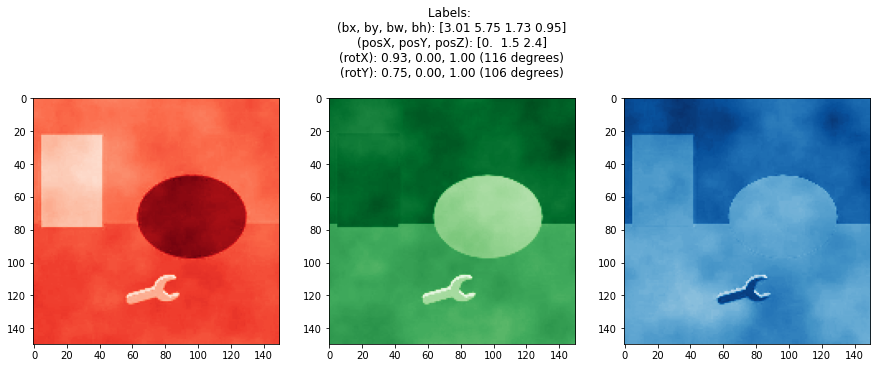

In [122]:
random_index = random.randrange(IMAGES)
fig, axs = plt.subplots(ncols = 3, figsize = (15, 15))

axs[0].imshow(X[random_index][:, :, 0], cmap="Reds")
axs[1].imshow(X[random_index][:, :, 1], cmap="Greens")
axs[2].imshow(X[random_index][:, :, 2], cmap="Blues")

title = "Labels: \n\
(bx, by, bw, bh): {frameLabels}\n\
(posX, posY, posZ): {positionLabels}\n\
(rotX): {rx:.2f}, {gx:.2f}, {bx:.2f} ({xDegrees} degrees)\n\
(rotY): {ry:.2f}, {gy:.2f}, {by:.2f} ({yDegrees} degrees)\n".format(frameLabels = y[random_index][:4],
                              positionLabels = y[random_index][4:7],
                              rx = y[random_index][7],
                              gx = y[random_index][8],
                              bx =y[random_index][9],
                              ry = y[random_index][10],
                              gy = y[random_index][11],
                              by = y[random_index][12],
                              xDegrees = int(RGBToAngle(y[random_index][7:10])),
                              yDegrees = int(RGBToAngle(y[random_index][10:13])))

axs[1].set_title(title)

plt.show()

# Model

### Custom accuracy metric

In [111]:
def acc15(y_true, y_pred):
    threshold = 15
    count = tf.reduce_sum(tf.cast(K.less(K.abs(y_true-y_pred), threshold), tf.float32))

    return count

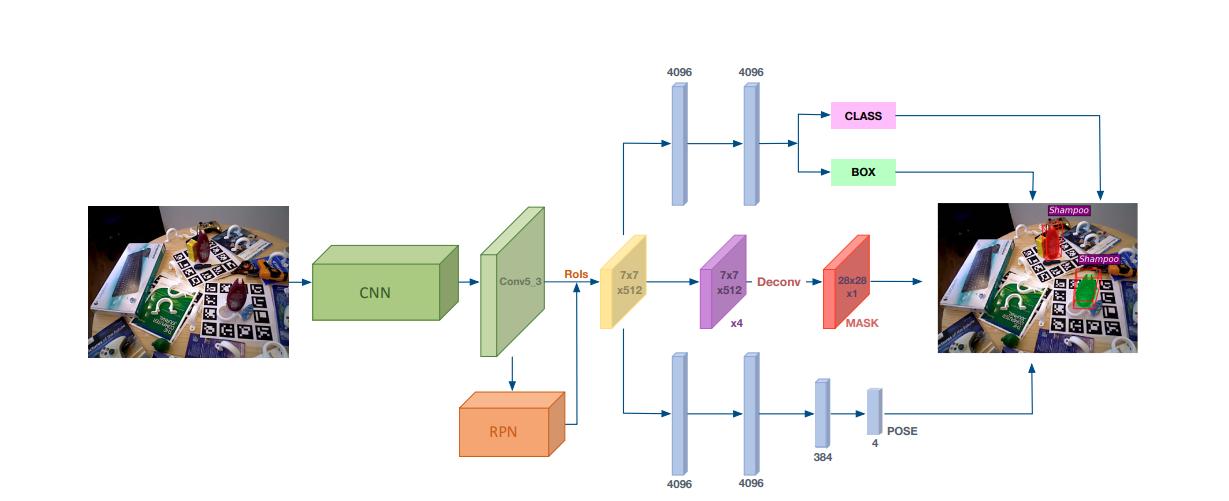

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
ms_conv_1 (Conv2D)              (None, 148, 148, 16) 448         Inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_20 (LeakyReLU)      (None, 148, 148, 16) 0           ms_conv_1[0][0]                  
__________________________________________________________________________________________________
ms_maxpooling_1 (MaxPooling2D)  (None, 74, 74, 16)   0           leaky_re_lu_20[0][0]             
______________________________________________________________________________________________

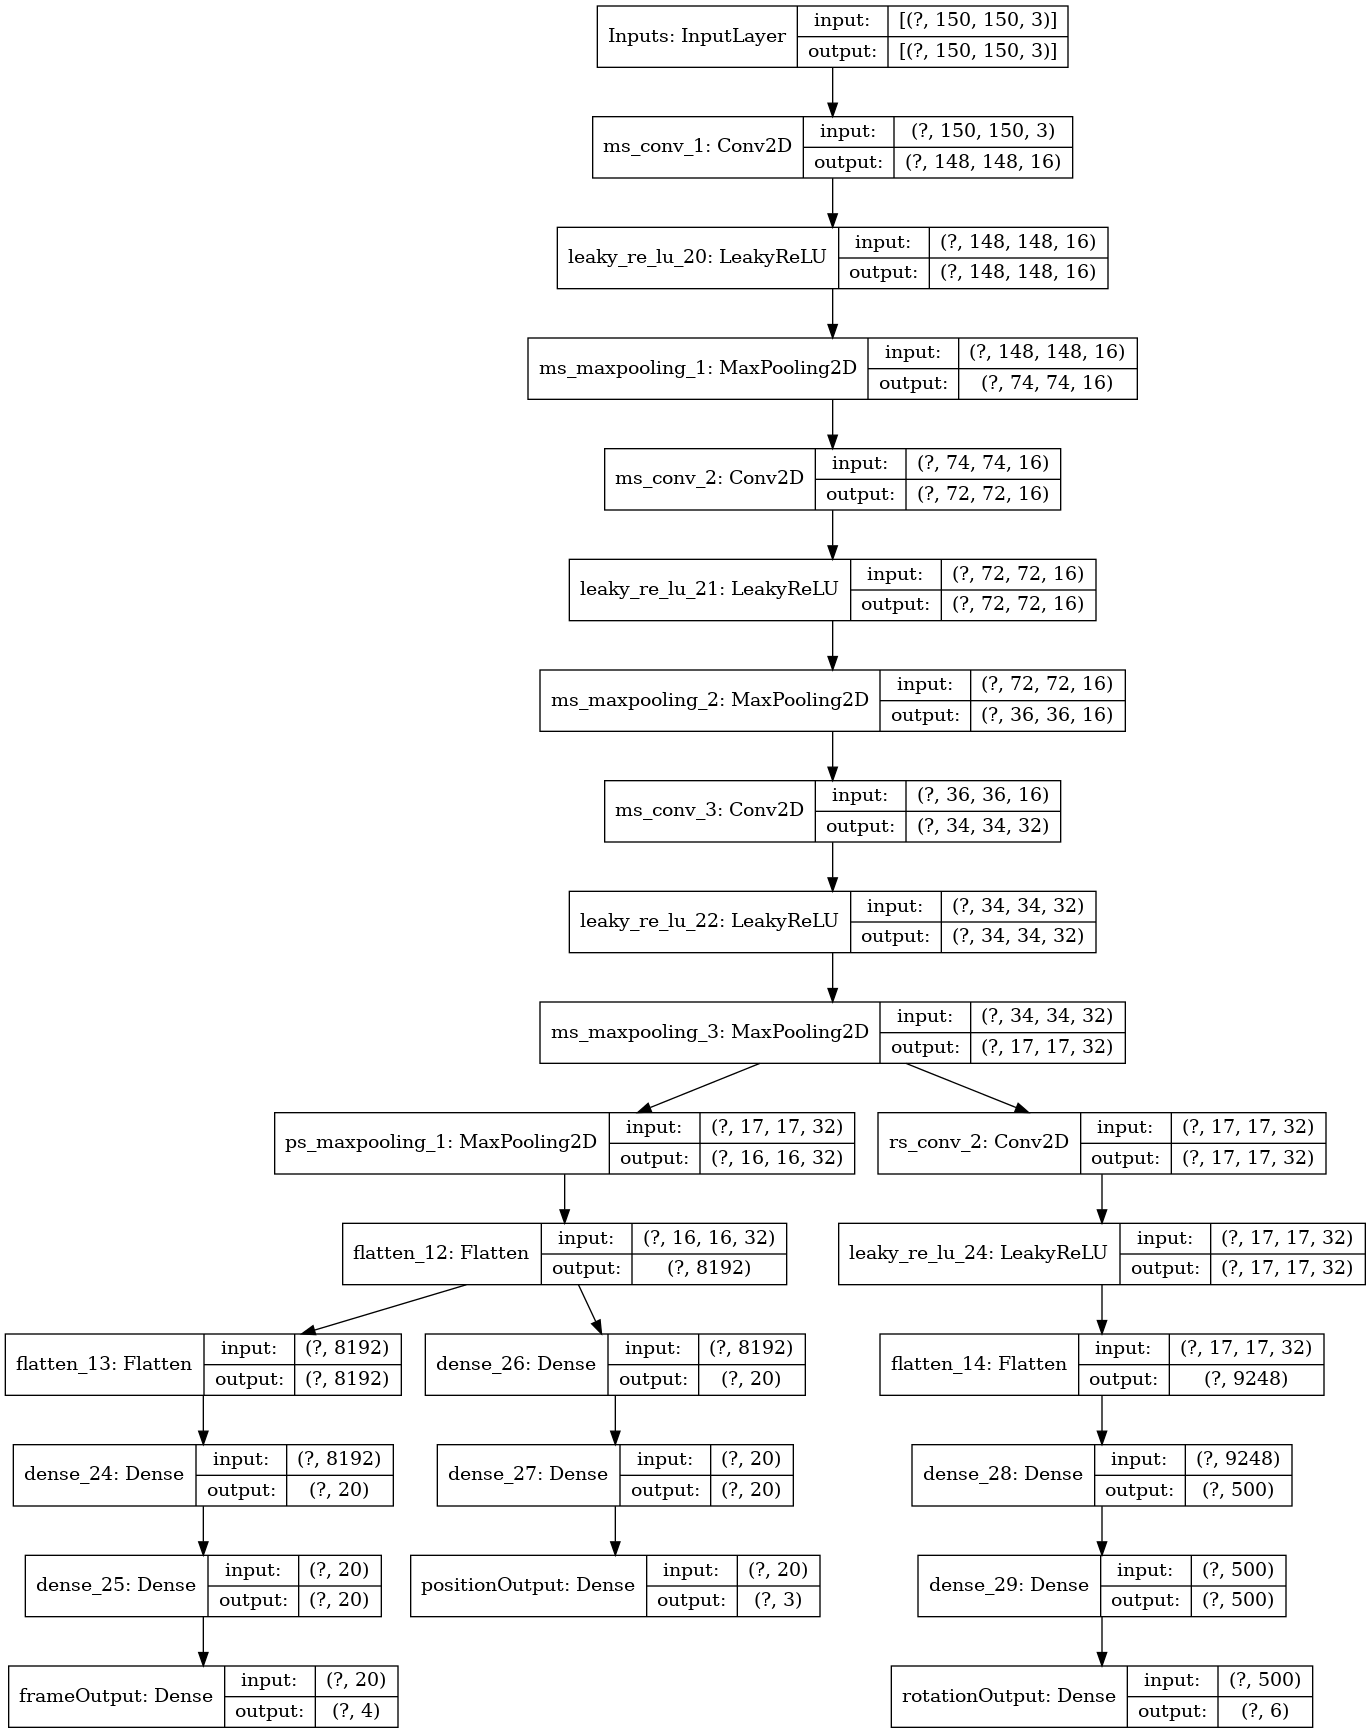

In [112]:
# Removing ps_maxpooling_2

inputs = Input(name = "Inputs",
              shape = (IMG_SIZE, IMG_SIZE, 3))

# Main Stream
mainStream = Conv2D(name = "ms_conv_1",
                   filters = 16,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(inputs)

mainStream = LeakyReLU()(mainStream)

mainStream = MaxPooling2D(name="ms_maxpooling_1", 
                          pool_size = (2, 2), 
                          strides = 2)(mainStream)

mainStream = Conv2D(name = "ms_conv_2",
                   filters = 16,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(mainStream)
#                     kernel_initializer='he_uniform')(mainStream)


mainStream = LeakyReLU()(mainStream)

mainStream = MaxPooling2D(name="ms_maxpooling_2", 
                          pool_size = (2, 2), 
                          strides = 2)(mainStream)

mainStream = Conv2D(name = "ms_conv_3",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(mainStream)

mainStream = LeakyReLU()(mainStream)

mainStream = MaxPooling2D(name="ms_maxpooling_3", 
                          pool_size = (2, 2), 
                          strides = 2)(mainStream)


# Position Stream
positionStream = MaxPooling2D(name="ps_maxpooling_1", 
                          pool_size = (2, 2), 
                          strides = 1)(mainStream)

# positionStream = MaxPooling2D(name="ps_maxpooling_2", 
#                           pool_size = (2, 2), 
#                           strides = 2)(positionStream)

positionStream = Flatten()(positionStream)

# Frame Stream
frameStream = Flatten()(positionStream)
frameStream = Dense(20, activation = "relu")(frameStream)
frameStream = Dense(20, activation = "relu")(frameStream)
frameStream = Dense(4, name = "frameOutput")(frameStream)

positionStream = Dense(20, activation = "relu")(positionStream)
positionStream = Dense(20, activation = "relu")(positionStream)
positionStream = Dense(3, name = "positionOutput")(positionStream)

# Rotation Stream
roationStream = Conv2D(name = "rs_conv_1",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "same",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(mainStream)

roationStream = LeakyReLU()(roationStream)

roationStream = Conv2D(name = "rs_conv_2",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "same",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(mainStream)

roationStream = LeakyReLU()(roationStream)

roationStream = Flatten()(roationStream)
roationStream = Dense(500, activation = "relu")(roationStream)
roationStream = Dense(500, activation = "relu")(roationStream)
roationStream = Dense(6, name = "rotationOutput")(roationStream)


model = keras.Model(inputs, [positionStream, roationStream, frameStream], name = "Model")

model_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    amsgrad=False)

model_loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer = model_optimizer,
             loss = [model_loss, model_loss, model_loss])

model.summary()
keras.utils.plot_model(model, "model.png", show_shapes=True)

# Training

In [113]:
history = model.fit(x = X,
                   y = {"frameOutput": y[:, 0:4], "positionOutput": y[:, 4:7], "rotationOutput": y[:, 7:13]},
                   batch_size = 32,
                   epochs = 15,
                   validation_split = 0.2)

Epoch 1/15
25/25 [==============================] - 5s 198ms/step - loss: 4.2217 - positionOutput_loss: 1.0356 - rotationOutput_loss: 0.2721 - frameOutput_loss: 2.9140 - val_loss: 2.5778 - val_positionOutput_loss: 0.5809 - val_rotationOutput_loss: 0.2207 - val_frameOutput_loss: 1.7762
Epoch 2/15
25/25 [==============================] - 5s 193ms/step - loss: 1.9501 - positionOutput_loss: 0.4079 - rotationOutput_loss: 0.1968 - frameOutput_loss: 1.3455 - val_loss: 1.6770 - val_positionOutput_loss: 0.3400 - val_rotationOutput_loss: 0.2039 - val_frameOutput_loss: 1.1331
Epoch 3/15
25/25 [==============================] - 5s 192ms/step - loss: 1.2232 - positionOutput_loss: 0.2441 - rotationOutput_loss: 0.1917 - frameOutput_loss: 0.7874 - val_loss: 1.1291 - val_positionOutput_loss: 0.2447 - val_rotationOutput_loss: 0.2106 - val_frameOutput_loss: 0.6738
Epoch 4/15
25/25 [==============================] - 5s 185ms/step - loss: 0.8467 - positionOutput_loss: 0.1849 - rotationOutput_loss: 0.1765 -

loss
positionOutput_loss
rotationOutput_loss
frameOutput_loss
val_loss
val_positionOutput_loss
val_rotationOutput_loss
val_frameOutput_loss


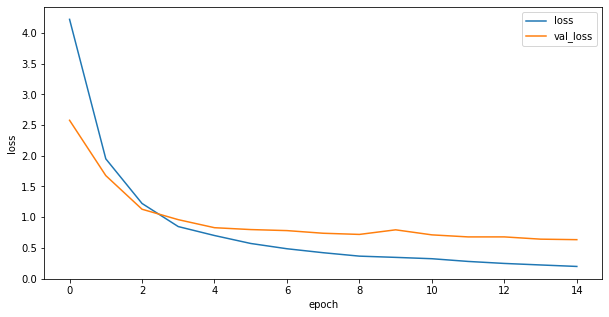

In [114]:
for k in history.history.keys():
    print(k)

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10,5))

axs.plot(history.history['loss'], label = "loss")
axs.plot(history.history['val_loss'], label = "val_loss")
axs.set_ylabel('loss')
axs.set_xlabel('epoch')
axs.legend(loc='upper right')

plt.show()

# Results

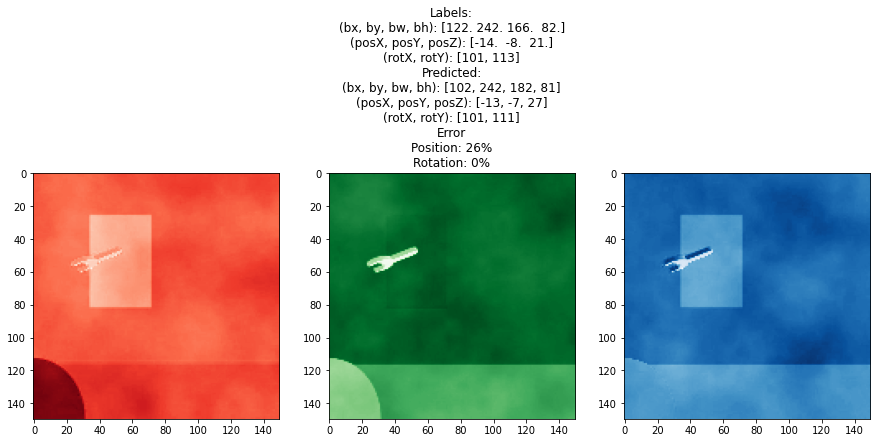

In [126]:
random_index = random.randrange(IMAGES)

prediction = model.predict(X[random_index].reshape(1, IMG_SIZE, IMG_SIZE, 3))

fig, axs = plt.subplots(ncols = 3, figsize = (15, 15))

axs[0].imshow(X[random_index][:, :, 0], cmap="Reds")
axs[1].imshow(X[random_index][:, :, 1], cmap="Greens")
axs[2].imshow(X[random_index][:, :, 2], cmap="Blues")

frame_og = y[random_index][:4]*100
pos_og = y[random_index][4:7]*10
rot_og = [int(RGBToAngle(y[random_index][7:10])), int(RGBToAngle(y[random_index][10:13]))]

frame_pred = [int(p*100) for p in prediction[2][0]]
pos_pred = [int(p*10) for p in prediction[0][0]]
rot_pred = [int(RGBToAngle(prediction[1][0][0:3])), int(RGBToAngle(prediction[1][0][3:7]))]

pos_error = int(sum((abs(pos_pred-pos_og)/30)*100))
rot_error = int(sum([abs((rot_pred[0]-rot_og[0])/360), abs(rot_pred[1]-rot_og[1])/360])*100)

axs[1].set_title(f"Labels:\
\n(bx, by, bw, bh): {frame_og}\
\n(posX, posY, posZ): {pos_og}\
\n(rotX, rotY): {rot_og}\n\
Predicted:\
\n(bx, by, bw, bh): {frame_pred}\
\n(posX, posY, posZ): {pos_pred}\
\n(rotX, rotY): {rot_pred}\
\nError\
\nPosition: {pos_error}%\
\nRotation: {rot_error}%")

plt.show()

# Layer output extraction

In [127]:
def extract_layer_data(layer):
    submodel = keras.Model(inputs = model.input, outputs = layer.output)
    submodel_output = submodel.predict(np.array(X[random_index]).reshape(1, IMG_SIZE, IMG_SIZE, 3))
    output_shape = submodel_output.shape
    
    graph_size = 10
    
    index = 0
    if (len(output_shape) != 2):
        if(output_shape[-1]>=4):
            fig, axs = plt.subplots(4, int(output_shape[-1]/4), figsize=(graph_size, graph_size))
            fig.suptitle(f"{layer.name}, [{output_shape}]")
            for col in range(0, 4):
                for row in range(0, int(output_shape[-1]/4)):
                    axs[col, row].imshow(submodel_output[0, :, :, index], cmap="Greys")
                    index += 1
                    axs[col, row].axis('off')
            
        else:
            fig, axs = plt.subplots(ncols = output_shape[-1], figsize=(graph_size, graph_size))
            for col in range(0, output_shape[-1]):
                axs[col].imshow(submodel_output[0, :, :, index], cmap="Greys")
                if(int(output_shape[-1]/2) == col):
                    axs[col].set_title(f"{layer.name}, [{output_shape}]")
                index += 1
                axs[col].axis('off')
    plt.tight_layout()

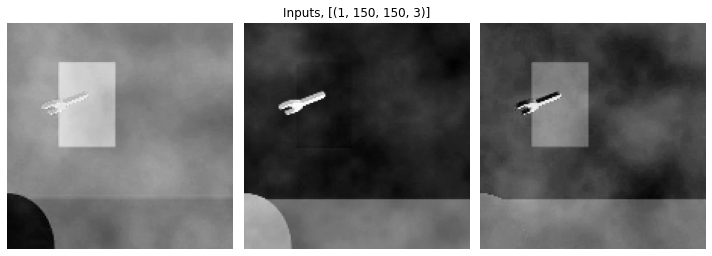

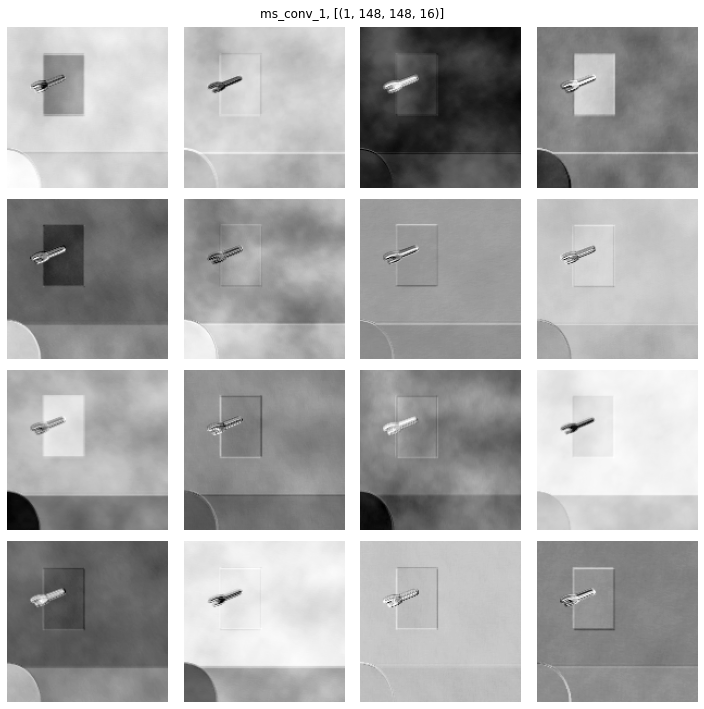

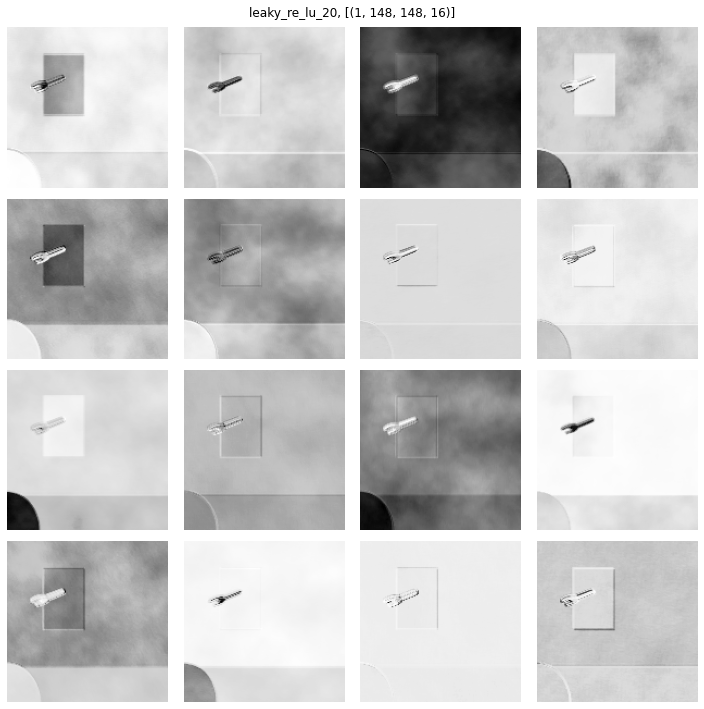

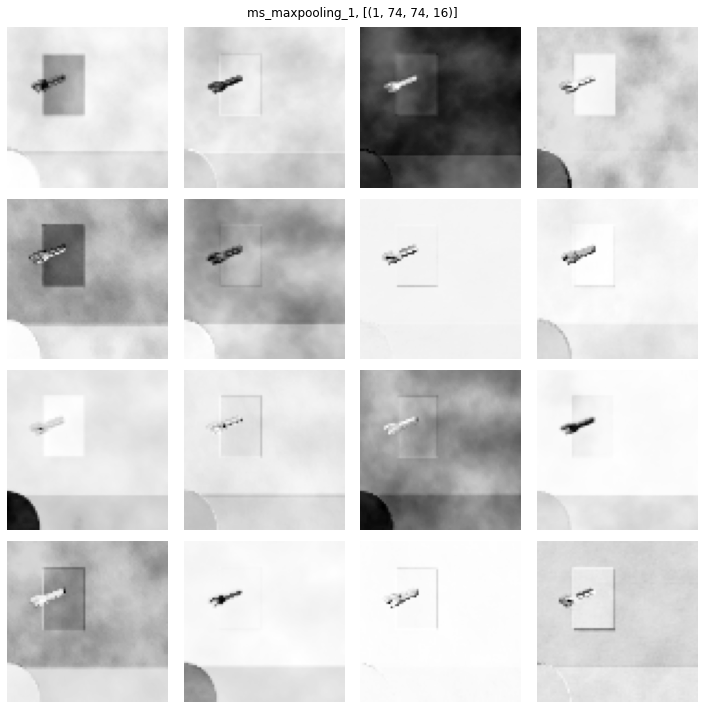

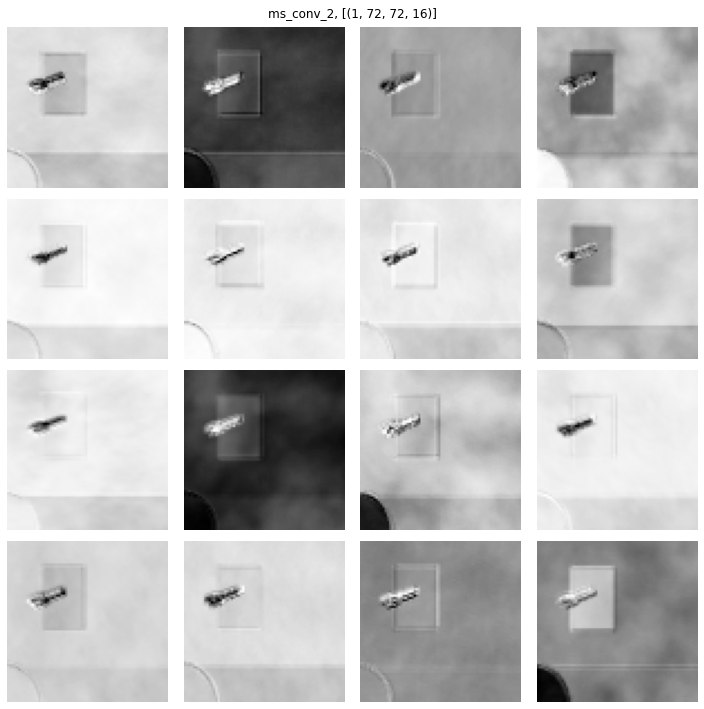

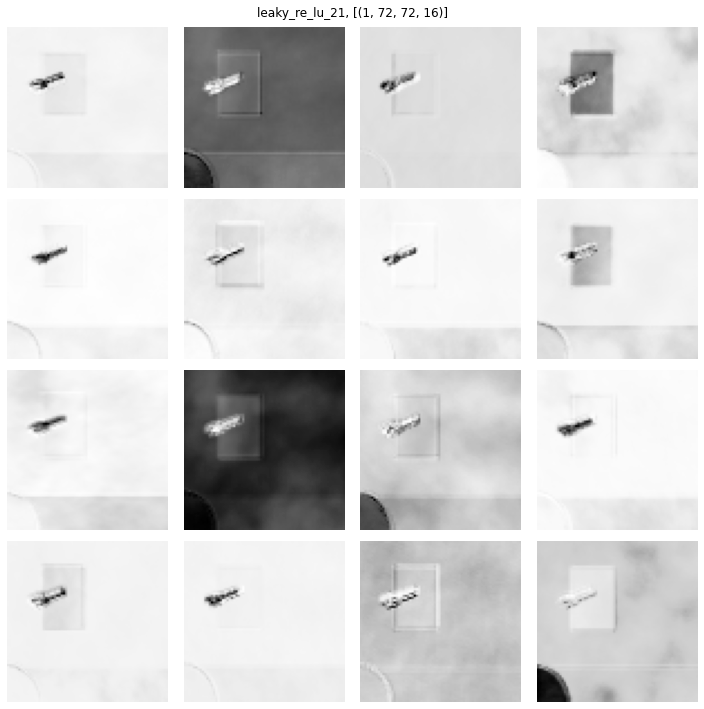

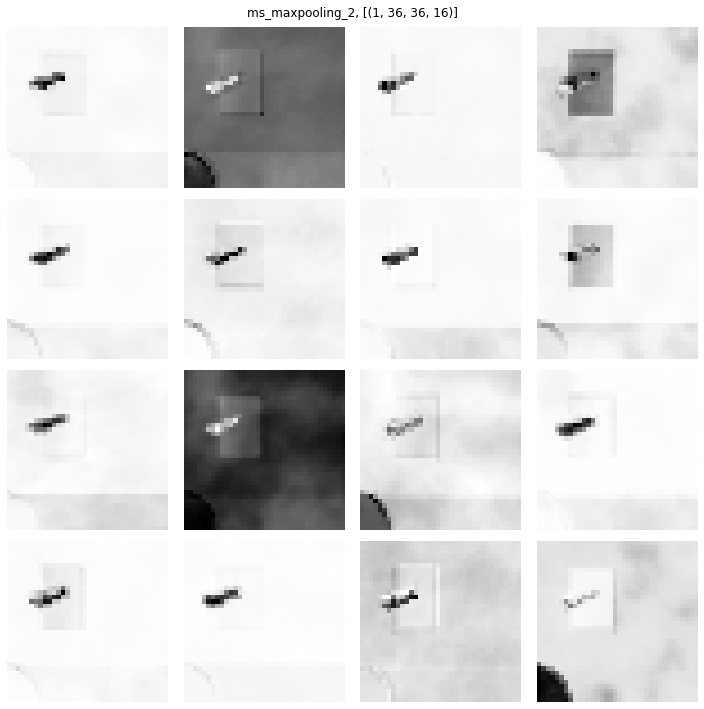

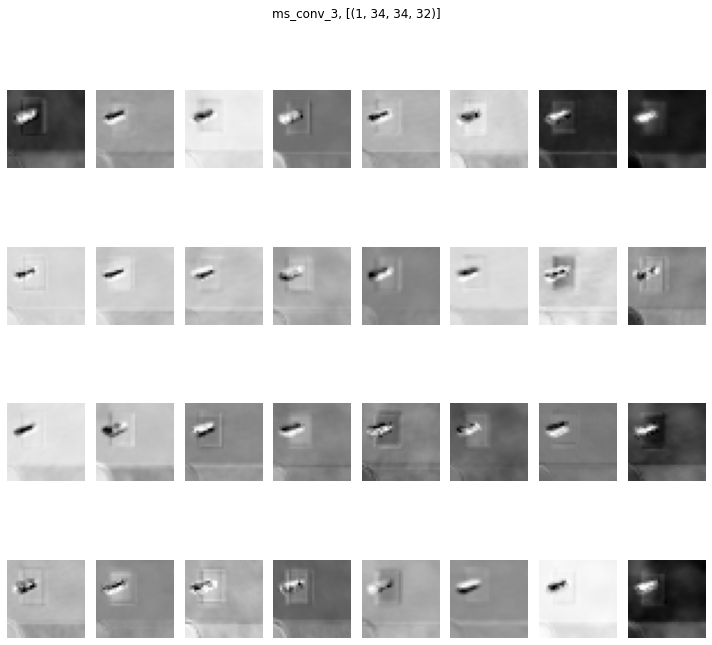

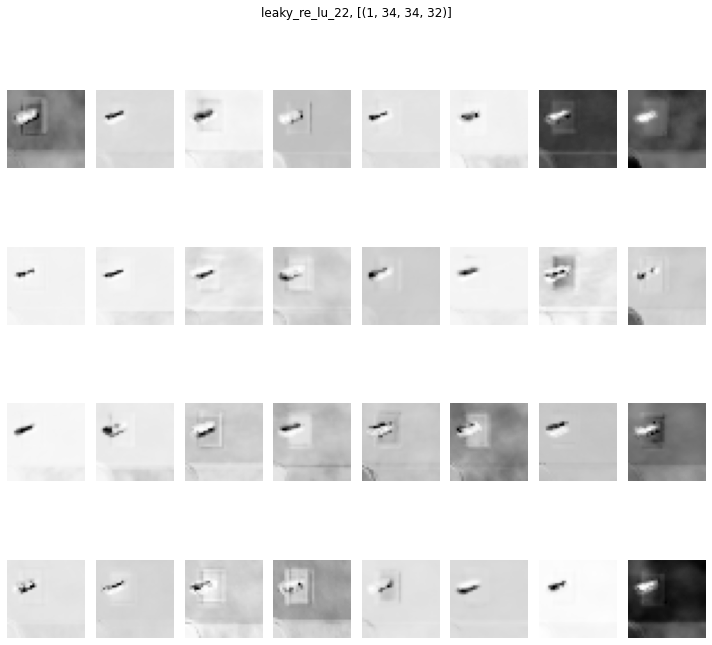

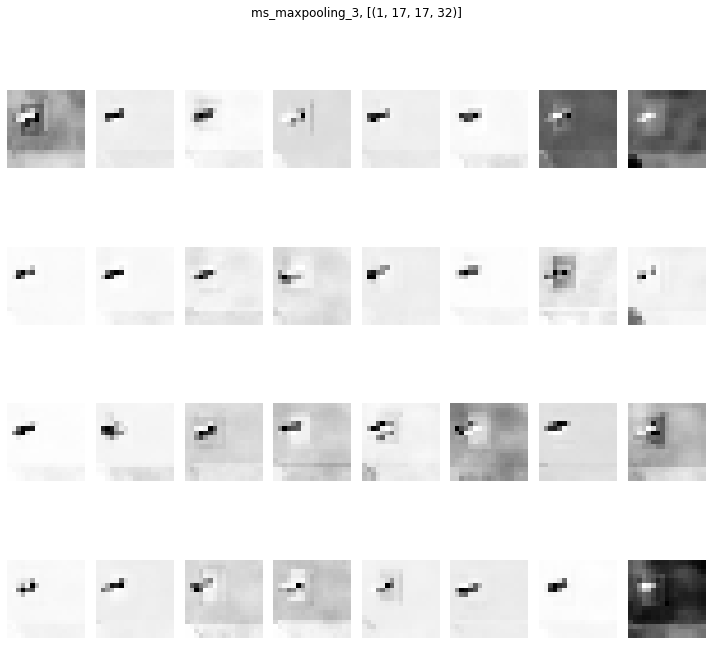

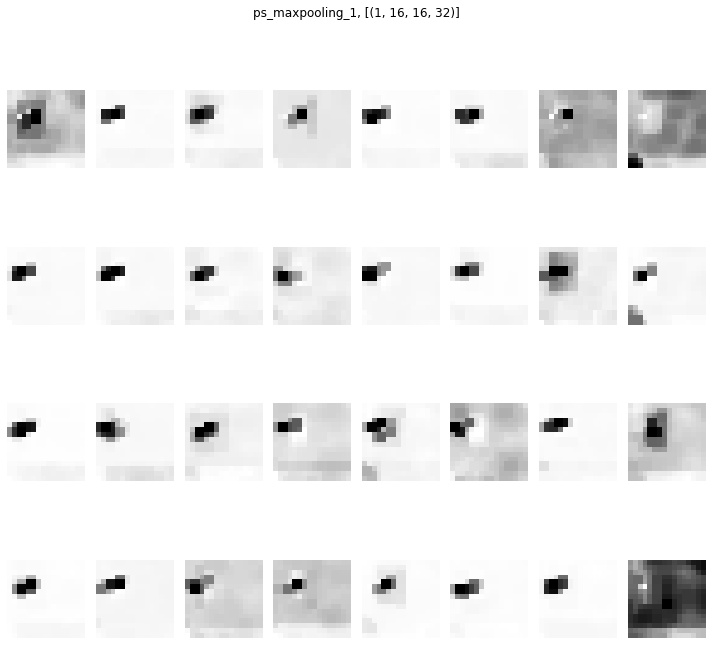

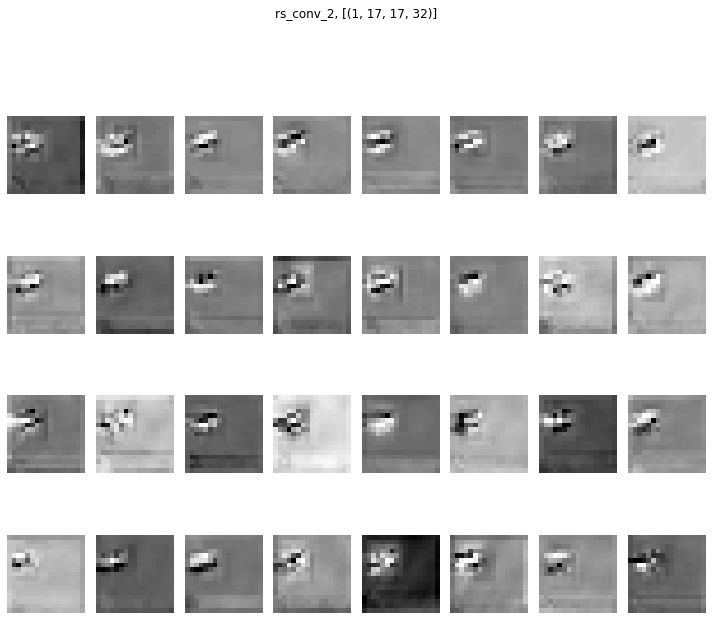

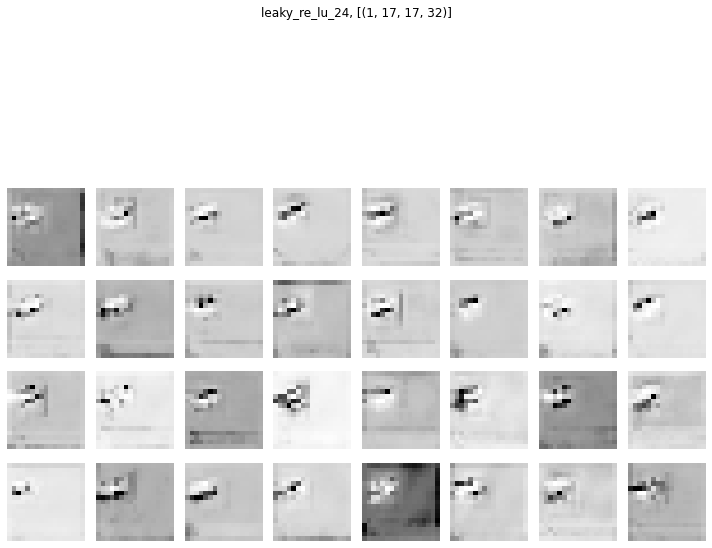

In [128]:
for layer in model.layers:
    extract_layer_data(layer)

In [67]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

In [73]:
plt.rcParams.update({'font.size': 15})